In [1]:
import csv, re
import pandas as pd
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline
import pyphen
import seaborn as sns
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
import time
start_time = time.time()


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# We import some of the parsing and loading methods we had from previous tasks
def parse_label(label):
    if label == '__label2__':
        return 'real'
    else:
        return 'fake'    

def parse_verification(label):
    if label == 'N':
        return 0
    else:
        return 1      

def flatten(lst):
    for el in lst:
        if isinstance(el, list):
            yield from el
        else:
            yield el    

# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], \
            reviewLine[8] + ' ' + reviewLine[7], \
            parse_label(reviewLine[1]), \
            reviewLine[2], \
            parse_verification(reviewLine[3]))

# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path,encoding="utf8") as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader, None)  # skip the headers        
        for line in reader:
            (Id, Text, Label, Rating, Verified) = parseReview(line)
            rawData.append((Id, Text, Label, Rating, Verified))
            
#Loading our set
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
reviewPath = 'amazon_reviews.txt'
loadData(reviewPath)
names = ['doc_id', 'label', 'rating', 'verified_purchase', \
         'pr_category', 'pr_id', 'pr_title', 'review_title', 'review_text']
reviewData = pd.read_csv('amazon_reviews.txt', names=names, sep='\t')

In [3]:
reviewData.describe()

,doc_id,label,rating,verified_purchase,pr_category,pr_id,pr_title,review_title,review_text
count,21001,21001,21001,21001,21001,21001,21001,21001,21001
unique,21001,3,6,3,31,18858,18866,18477,21001
top,DOC_ID,__label1__,5,Y,Books,B0010O748Q,Honey Badger Garden Gloves for Digging & Plant...,Five Stars,REVIEW_TEXT
freq,1,10500,12210,11698,700,4,5,83,1


In [4]:
reviewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21001 entries, 0 to 21000
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   doc_id             21001 non-null  object
 1   label              21001 non-null  object
 2   rating             21001 non-null  object
 3   verified_purchase  21001 non-null  object
 4   pr_category        21001 non-null  object
 5   pr_id              21001 non-null  object
 6   pr_title           21001 non-null  object
 7   review_title       21001 non-null  object
 8   review_text        21001 non-null  object
dtypes: object(9)
memory usage: 1.4+ MB


In [5]:
reviewData.head(5)

,doc_id,label,rating,verified_purchase,pr_category,pr_id,pr_title,review_title,review_text
0,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
1,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
2,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
3,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
4,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...


In [6]:
#dataframe, with some additional features
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline
import pyphen
dic = pyphen.Pyphen(lang='en')
stop_words = set(stopwords.words('english'))

def averageLen(lst):
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths)) 


names = ['doc_id', 'label', 'rating', 'verified_purchase', \
         'pr_category', 'pr_id', 'pr_title', 'review_title', 'review_text']
data = pd.read_csv('amazon_reviews.txt', skiprows=[0], names=names, sep='\t')
data['verified_purchase'] = data['verified_purchase'].apply(lambda x: 1 if x=='Y' else 0)
data['label'] = data['label'].apply(lambda x: 'real' if x=='__label2__' else 'fake')
data['review_text_length'] = data.apply(lambda row: len(row.review_text), axis=1)
data['review_title_length'] = data.apply(lambda row: len(row.review_title), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"<[^>]*>", "", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: nltk.word_tokenize(row['tokenized_review'].lower()), axis=1)
data['tokenized_review_string'] = data['tokenized_review'].apply(' '.join)
data['tokens'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['tokens'] = data.apply(lambda row: [t for t in row['tokens'] if t not in stop_words], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t in stopwords.words('english')], axis=1)
data['num_tokens'] = data.apply(lambda row: len(row['tokens']), axis=1)
data['avg_len_tokens'] = data.apply(lambda row: averageLen(row['tokens']), axis=1)
data['num_stopwords'] = data.apply(lambda row: len(row['stopwords']), axis=1)
data['word_count'] = data.apply(lambda row: len(row['tokenized_review']), axis=1)
data['sent_count'] = data.apply(lambda row: len(sent_tokenize(row['review_text'])), axis=1)
data['syll_count'] = data.apply(lambda row: len(list(flatten([dic.inserted(text).split('-') for text in row['tokenized_review']]))), axis=1)
data['flesch_kincaid'] = data.apply(lambda row: 206.835 - 1.015*row['word_count']/row['sent_count'] - 84.6*row['syll_count']/row['word_count'], axis=1)

In [7]:
data_2 = data.copy(deep=True)
data_2 = data_2.drop(['doc_id'], axis=1)

In [8]:
data_3 = data.copy(deep=True)
data_3 = data_3.drop(['doc_id'], axis=1)
data_3['label']= data_3['label'].apply(lambda x: 1 if x=='real' else 0)
data_3

,label,rating,verified_purchase,pr_category,pr_id,pr_title,review_title,review_text,review_text_length,review_title_length,...,tokenized_review_string,tokens,stopwords,num_tokens,avg_len_tokens,num_stopwords,word_count,sent_count,syll_count,flesch_kincaid
0,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",116,6,...,"when least you think so , this product will sa...","[least, think, product, save, day, keep, aroun...","[when, you, so, this, will, the, just, it, jus...",10,5.100000,13,26,2,27,105.786154
1,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,404,21,...,lithium batteries are something new introduced...,"[lithium, batteries, something, new, introduce...","[are, in, the, there, is, but, doesn, t, on, a...",39,6.256410,31,74,2,103,51.525946
2,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,248,24,...,i purchased this swing for my baby . she is 6 ...,"[purchased, swing, baby, months, pretty, much,...","[i, this, for, my, she, is, now, and, has, out...",19,5.421053,34,62,5,67,102.826419
3,0,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,212,16,...,i was looking for an inexpensive desk calcolat...,"[looking, inexpensive, desk, calcolatur, works...","[i, was, for, an, and, here, it, is, it, and, ...",19,5.473684,25,48,4,55,97.717500
4,0,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,331,21,...,i only use it twice a week and the results are...,"[use, twice, week, results, great, used, teeth...","[i, only, it, a, and, the, are, i, have, other...",27,5.629630,39,72,3,82,86.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1,4,1,Shoes,B00BXYM8T8,"Madden Girl Women's Gettaw Pump,Red Patent,7.5...",wide width is great!,"I bought these for work. I have high arches, ...",100,20,...,"i bought these for work . i have high arches ,...","[bought, work, high, arches, use, arch, suppor...","[i, these, for, i, have, so, i, an, the, are, ...",9,4.777778,12,25,3,26,110.392667
20996,1,4,1,Shoes,B0014C2ORK,"crocs Unisex Classic Clog,Khaki,6 US Men's / 8...",Love crocs!,Crocs are one of only two brands of shoes that...,115,11,...,crocs are one of only two brands of shoes that...,"[crocs, one, two, brands, shoes, feet, day, wo...","[are, of, only, of, that, i, can, be, on, my, ...",13,4.538462,12,27,2,29,102.265833
20997,1,5,1,Shoes,B000EX8CCQ,Minnetonka Men's 703 Leather Laced Softsole Mo...,I love moccasins This fit like it was custom m...,I love moccasins This fit like it was custom ...,297,57,...,i love moccasins this fit like it was custom m...,"[love, moccasins, fit, like, custom, made, sof...","[i, this, it, was, for, me, very, and, so, i, ...",27,5.592593,29,62,3,77,80.790591
20998,1,5,1,Shoes,B00748YHVE,Ariat Womens Unbridled Fatbaby 9 B Powder Brown,"This fit well, comfortable, best investment",I wish these were a little more durable. I got...,287,43,...,i wish these were a little more durable . i go...,"[wish, little, durable, got, caught, bolt, cro...","[i, these, were, a, more, i, it, on, a, the, a...",28,5.071429,29,63,6,71,100.834643


In [9]:
#data_3 = data_2
data_2['label'] = data_2['label'].apply(lambda x: 1 if x=='real' else 0)
data_2.describe

<bound method NDFrame.describe of        label  rating  verified_purchase      pr_category       pr_id  \
0          0       4                  0               PC  B00008NG7N   
1          0       4                  1         Wireless  B00LH0Y3NM   
2          0       3                  0             Baby  B000I5UZ1Q   
3          0       4                  0  Office Products  B003822IRA   
4          0       4                  0           Beauty  B00PWSAXAM   
...      ...     ...                ...              ...         ...   
20995      1       4                  1            Shoes  B00BXYM8T8   
20996      1       4                  1            Shoes  B0014C2ORK   
20997      1       5                  1            Shoes  B000EX8CCQ   
20998      1       5                  1            Shoes  B00748YHVE   
20999      1       4                  1            Shoes  B00A46KTLU   

                                                pr_title  \
0            Targus PAUK10U Ultra Mini US

In [10]:
data_2.describe()

,label,rating,verified_purchase,review_text_length,review_title_length,num_tokens,avg_len_tokens,num_stopwords,word_count,sent_count,syll_count,flesch_kincaid
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.500000,4.127952,0.557048,372.326429,25.978619,33.606238,5.596324,36.203333,81.902095,4.445857,98.581524,86.118686
std,0.500012,1.278333,0.496747,480.508503,19.032716,43.044102,0.542849,44.062376,103.987352,4.159245,128.954947,15.649053
min,0.000000,1.000000,0.000000,98.000000,1.000000,5.000000,2.500000,0.000000,16.000000,1.000000,17.000000,-218.137911
25%,0.000000,4.000000,0.000000,156.000000,13.000000,14.000000,5.238095,15.000000,35.000000,2.000000,41.000000,80.562218
50%,0.500000,5.000000,1.000000,236.000000,20.000000,21.000000,5.562940,24.000000,52.000000,3.000000,62.000000,88.680000
75%,1.000000,5.000000,1.000000,388.000000,33.000000,35.000000,5.919355,39.000000,86.000000,5.000000,103.000000,95.587250
max,1.000000,5.000000,1.000000,16188.000000,128.000000,1379.000000,8.923077,1557.000000,3382.000000,112.000000,4212.000000,115.383750


In [11]:
data_2.head(5)

,label,rating,verified_purchase,pr_category,pr_id,pr_title,review_title,review_text,review_text_length,review_title_length,...,tokenized_review_string,tokens,stopwords,num_tokens,avg_len_tokens,num_stopwords,word_count,sent_count,syll_count,flesch_kincaid
0,0,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",116,6,...,"when least you think so , this product will sa...","[least, think, product, save, day, keep, aroun...","[when, you, so, this, will, the, just, it, jus...",10,5.100000,13,26,2,27,105.786154
1,0,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,404,21,...,lithium batteries are something new introduced...,"[lithium, batteries, something, new, introduce...","[are, in, the, there, is, but, doesn, t, on, a...",39,6.256410,31,74,2,103,51.525946
2,0,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,248,24,...,i purchased this swing for my baby . she is 6 ...,"[purchased, swing, baby, months, pretty, much,...","[i, this, for, my, she, is, now, and, has, out...",19,5.421053,34,62,5,67,102.826419
3,0,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,212,16,...,i was looking for an inexpensive desk calcolat...,"[looking, inexpensive, desk, calcolatur, works...","[i, was, for, an, and, here, it, is, it, and, ...",19,5.473684,25,48,4,55,97.717500
4,0,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,331,21,...,i only use it twice a week and the results are...,"[use, twice, week, results, great, used, teeth...","[i, only, it, a, and, the, are, i, have, other...",27,5.629630,39,72,3,82,86.125000


In [12]:
cor = data_2.corr()
cor

,label,rating,verified_purchase,review_text_length,review_title_length,num_tokens,avg_len_tokens,num_stopwords,word_count,sent_count,syll_count,flesch_kincaid
label,1.000000,0.009797,0.569816,0.116081,0.105793,0.116451,-0.035061,0.106905,0.116832,0.100742,0.115235,-0.015094
rating,0.009797,1.000000,0.101632,-0.013766,-0.032512,-0.003379,0.023139,-0.025454,-0.016653,0.009646,-0.015118,0.008737
verified_purchase,0.569816,0.101632,1.000000,-0.081607,0.086837,-0.079255,-0.040905,-0.082641,-0.080605,-0.063791,-0.083100,0.044601
review_text_length,0.116081,-0.013766,-0.081607,1.000000,0.214914,0.995985,0.064741,0.981702,0.995730,0.869479,0.997671,-0.283387
review_title_length,0.105793,-0.032512,0.086837,0.214914,1.000000,0.215295,0.033577,0.206535,0.213867,0.162450,0.214731,-0.135456
num_tokens,0.116451,-0.003379,-0.079255,0.995985,0.215295,1.000000,0.042009,0.968247,0.992128,0.870495,0.994293,-0.278345
avg_len_tokens,-0.035061,0.023139,-0.040905,0.064741,0.033577,0.042009,1.000000,0.022534,0.030507,0.027461,0.063834,-0.338813
num_stopwords,0.106905,-0.025454,-0.082641,0.981702,0.206535,0.968247,0.022534,1.000000,0.984405,0.868164,0.977395,-0.249242
word_count,0.116832,-0.016653,-0.080605,0.995730,0.213867,0.992128,0.030507,0.984405,1.000000,0.878734,0.997357,-0.264702
sent_count,0.100742,0.009646,-0.063791,0.869479,0.162450,0.870495,0.027461,0.868164,0.878734,1.000000,0.871666,0.035654


In [ ]:
plt.figure(figsize=(30,10))
sns.heatmap(cor, annot=True)
plt.show()

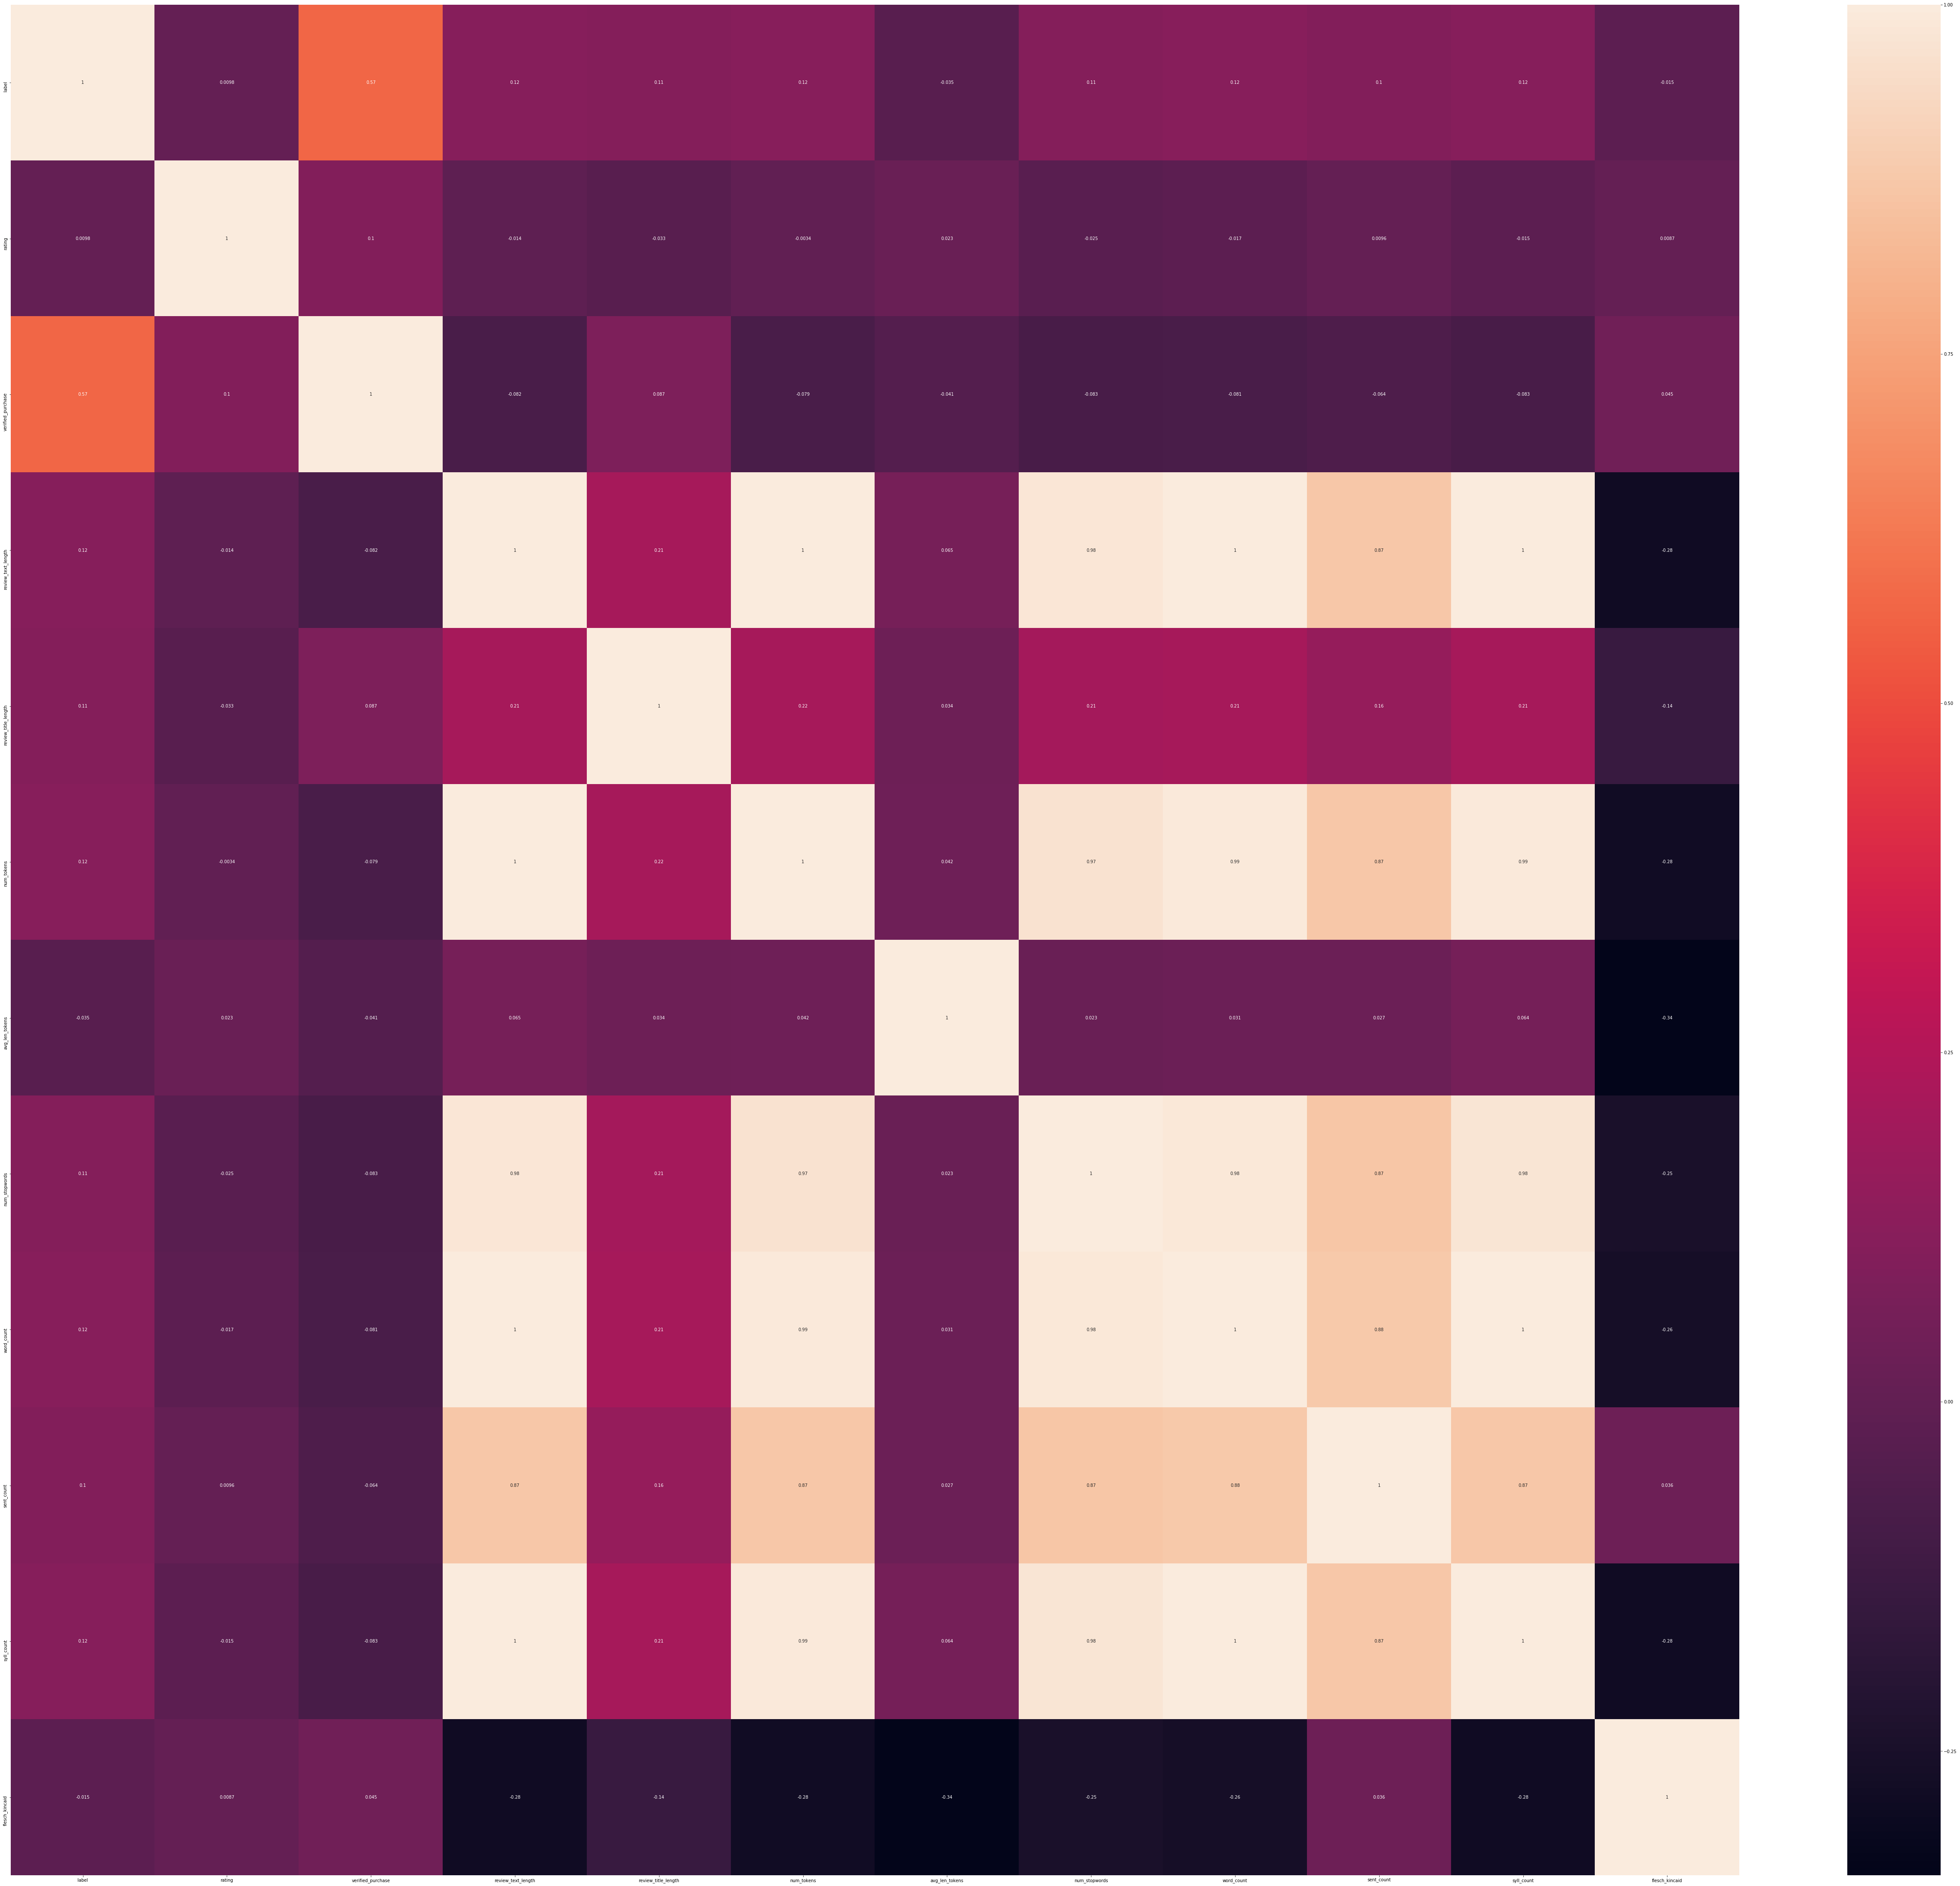

In [13]:
plt.figure(figsize=(90,80))

# heatmap
sns.heatmap(cor, annot=True)
plt.show()

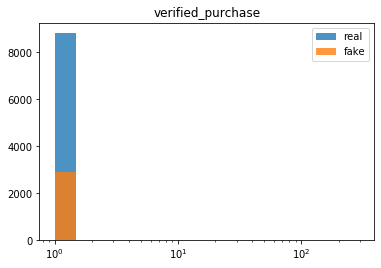

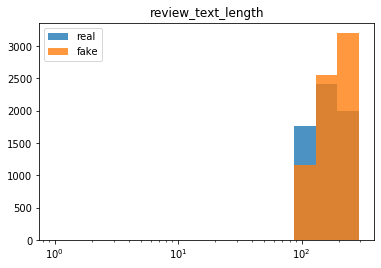

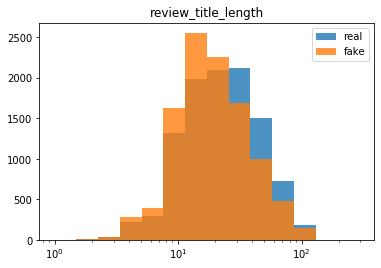

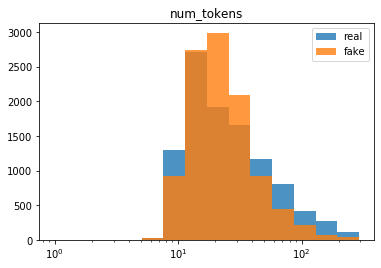

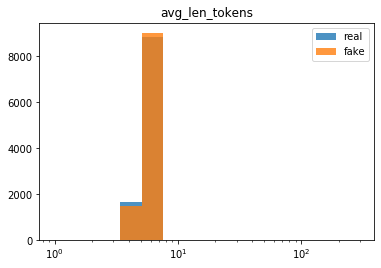

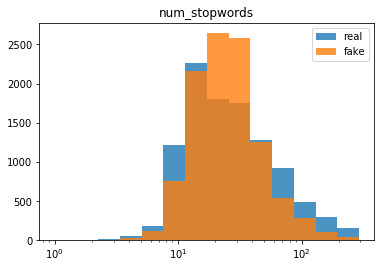

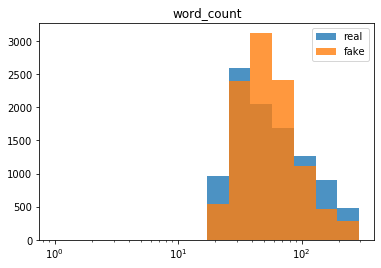

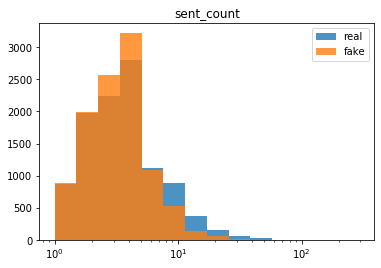

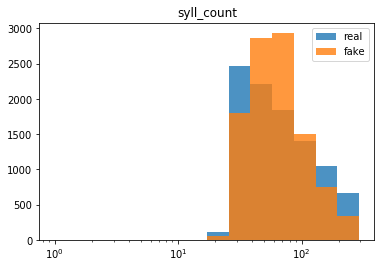

In [14]:
# plt.figure(figsize=(35,35))
# plt.subplot(1,2,1)
plt.title('verified_purchase')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['verified_purchase'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['verified_purchase'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(122)
plt.title('review_text_length')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['review_text_length'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['review_text_length'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,3)
plt.title('review_title_length')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['review_title_length'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['review_title_length'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,4)
plt.title('num_tokens')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['num_tokens'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['num_tokens'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,5)
plt.title('avg_len_tokens')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['avg_len_tokens'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['avg_len_tokens'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,6)
plt.title('num_stopwords')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['num_stopwords'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['num_stopwords'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,7)
plt.title('word_count')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['word_count'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['word_count'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,9)
plt.title('sent_count')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['sent_count'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['sent_count'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()

# plt.subplot(8,8,10)
plt.title('syll_count')
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(data[data['label']=='real']['syll_count'],bins=bins,alpha=0.8)
plt.hist(data[data['label']=='fake']['syll_count'],bins=bins,alpha=0.8)
plt.legend(('real','fake'))
plt.show()


REAL REVIEWS


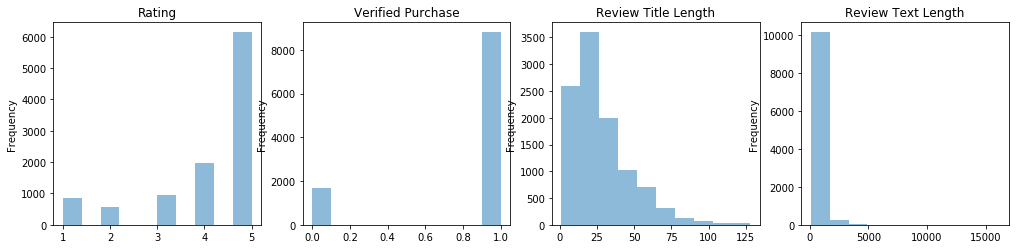

FAKE REVIEWS


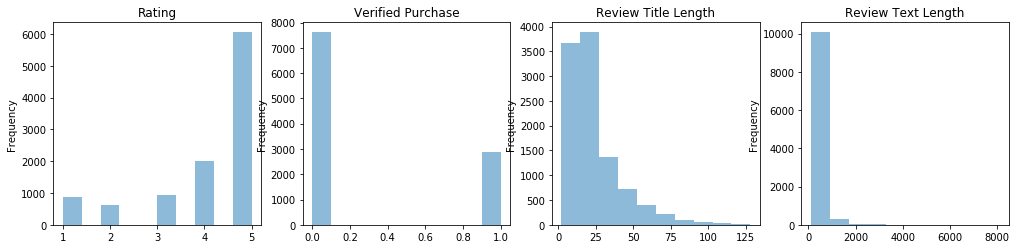

In [15]:
#To start the real reviews, let's look at some some statistics
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 
plt.figure(figsize=(35,35))

print('REAL REVIEWS')
# print('Rating stats:')
# print(data['rating'].describe())
plt.subplot(8,8,1)
plt.title('Rating')
real_data['rating'].plot.hist(alpha=0.5)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Verified Purchase')
real_data['verified_purchase'].plot.hist(alpha=0.5)


# print('Title length stats:')
# print(data['review_title_length'].describe())
plt.subplot(8,8,3)
plt.title('Review Title Length')
real_data['review_title_length'].plot.hist(alpha=0.5)


# print('Review length stats:')
# print(data['review_text_length'].describe())
plt.subplot(8,8,4)
plt.title('Review Text Length')
real_data['review_text_length'].plot.hist(alpha=0.5)

plt.show()

plt.figure(figsize=(35,35))
print('FAKE REVIEWS')

# print('Rating stats:')
# print(data['rating'].describe())
plt.subplot(8,8,1)
plt.title('Rating')
fake_data['rating'].plot.hist(alpha=0.5)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Verified Purchase')
fake_data['verified_purchase'].plot.hist(alpha=0.5)


# print('Title length stats:')
# print(data['review_title_length'].describe())
plt.subplot(8,8,3)
plt.title('Review Title Length')
fake_data['review_title_length'].plot.hist(alpha=0.5)


# print('Review length stats:')
# print(data['review_text_length'].describe())
plt.subplot(8,8,4)
plt.title('Review Text Length')
fake_data['review_text_length'].plot.hist(alpha=0.5)

plt.show()

REAL REVIEWS


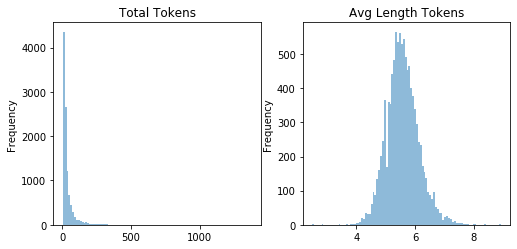

FAKE REVIEWS


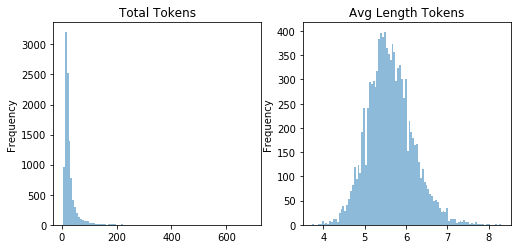

Real Data Avg Token Length: 5.58
Fake Data Avg Token Length: 5.62
Real Data Median Token Length: 5.55
Fake Data Median Token Length: 5.58
Real Data StDev Token Length: 0.54
Fake Data StDev Token Length: 0.54


In [16]:
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

plt.figure(figsize=(35,35))
print('REAL REVIEWS')
plt.subplot(8,8,1)
plt.title('Total Tokens')
real_data['num_tokens'].plot.hist(alpha=0.5, bins=100)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Avg Length Tokens')
real_data['avg_len_tokens'].plot.hist(alpha=0.5, bins=100)

plt.show()

plt.figure(figsize=(35,35))
print('FAKE REVIEWS')
plt.subplot(8,8,1)
plt.title('Total Tokens')
fake_data['num_tokens'].plot.hist(alpha=0.5, bins=100)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Avg Length Tokens')
fake_data['avg_len_tokens'].plot.hist(alpha=0.5, bins=100)

plt.show()

print('Real Data Avg Token Length: ' + str(round(real_data['avg_len_tokens'].mean(axis=0), 2)))
print('Fake Data Avg Token Length: ' + str(round(fake_data['avg_len_tokens'].mean(axis=0), 2)))

print('Real Data Median Token Length: ' + str(round(real_data['avg_len_tokens'].median(axis=0), 2)))
print('Fake Data Median Token Length: ' + str(round(fake_data['avg_len_tokens'].median(axis=0), 2)))

print('Real Data StDev Token Length: ' + str(round(real_data['avg_len_tokens'].std(axis=0), 2)))
print('Fake Data StDev Token Length: ' + str(round(fake_data['avg_len_tokens'].std(axis=0), 2)))

REAL vs FAKE F-K Score


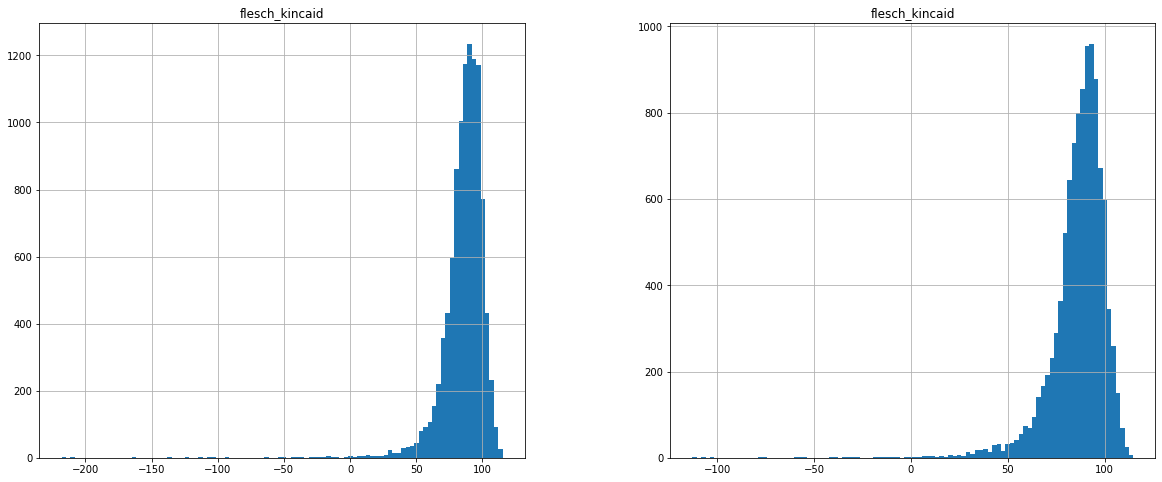

Real Data Avg FK score: 85.88
Fake Data Avg FK score: 86.35
Real Data Median FK score: 88.42
Fake Data Median FK score: 88.91
Real Data StDev FK score: 16.3
Fake Data StDev FK score: 14.97


In [17]:
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20,8)

print('REAL vs FAKE F-K Score')
plt.title('Real Reviews')
real_data.hist('flesch_kincaid', bins=100, ax=axes[0])

plt.title('Fake Reviews')
fake_data.hist('flesch_kincaid', bins=100, ax=axes[1])

plt.show()

print('Real Data Avg FK score: ' + str(round(real_data['flesch_kincaid'].mean(axis=0), 2)))
print('Fake Data Avg FK score: ' + str(round(fake_data['flesch_kincaid'].mean(axis=0), 2)))

print('Real Data Median FK score: ' + str(round(real_data['flesch_kincaid'].median(axis=0), 2)))
print('Fake Data Median FK score: ' + str(round(fake_data['flesch_kincaid'].median(axis=0), 2)))

print('Real Data StDev FK score: ' + str(round(real_data['flesch_kincaid'].std(axis=0), 2)))
print('Fake Data StDev FK score: ' + str(round(fake_data['flesch_kincaid'].std(axis=0), 2)))

REAL vs FAKE number of stopwords
Real Data Avg stopwords: 40.91
Fake Data Avg stopwords: 31.49
Real Data Median stopwords: 24.0
Fake Data Median stopwords: 24.0
Real Data StDev stopwords: 54.08
Fake Data StDev stopwords: 30.24


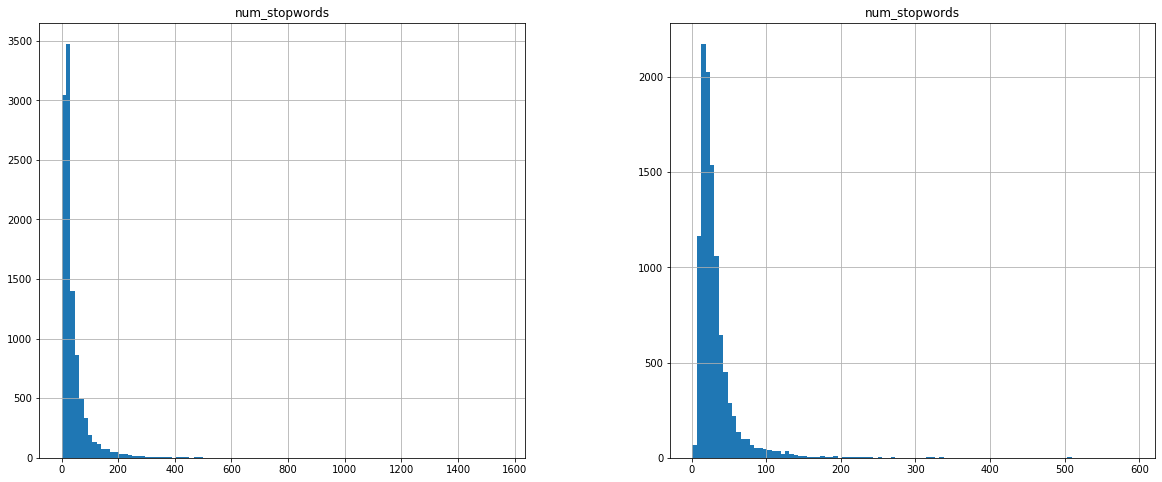

In [18]:
#What about stopwords?
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 


fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20,8)

print('REAL vs FAKE number of stopwords')
plt.title('Real Reviews')
real_data.hist('num_stopwords', bins=100, ax=axes[0])

plt.title('Fake Reviews')
fake_data.hist('num_stopwords', bins=100, ax=axes[1])

print('Real Data Avg stopwords: ' + str(round(real_data['num_stopwords'].mean(axis=0), 2)))
print('Fake Data Avg stopwords: ' + str(round(fake_data['num_stopwords'].mean(axis=0), 2)))

print('Real Data Median stopwords: ' + str(round(real_data['num_stopwords'].median(axis=0), 2)))
print('Fake Data Median stopwords: ' + str(round(fake_data['num_stopwords'].median(axis=0), 2)))

print('Real Data StDev stopwords: ' + str(round(real_data['num_stopwords'].std(axis=0), 2)))
print('Fake Data StDev stopwords: ' + str(round(fake_data['num_stopwords'].std(axis=0), 2)))

In [19]:
#Finally on to our classifier, the first thing is to add a column that will serve to capture the sentiment
def get_sent(rating):
    if rating < 3:
        sent = 'negative'
    elif rating > 3:
        sent = 'positive'
    else:
        sent = 'neutral'
    return sent

data['sentiment'] = data.apply(lambda row: get_sent(row['rating']), axis=1)

In [20]:
def plot_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(8, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Plot')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [54]:
y = data_2[['label']]
X_train, X_test, y_train, y_test = train_test_split(data_2['review_text'], y, test_size=0.33, random_state=1)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names()
tfidf_test = tfidf_vectorizer.transform(X_test)
nb_classifier = LinearSVC()
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
score

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6275613275613275

In [ ]:
metrics.confusion_matrix(y_test, pred)

In [22]:
#But we can also play with vectorizing ngrams instead of just unigrams
print('Unigrams only:')
tfidf_vectorizerUni = TfidfVectorizer(stop_words='english')
count_train = tfidf_vectorizerUni.fit_transform(X_train)
count_test = tfidf_vectorizerUni.transform(X_test)
nb_classifier = LinearSVC()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'neutral', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))

print('Ngrams:')
TfidfVectorizerNgram = TfidfVectorizer(ngram_range=(1, 7), analyzer='char')
count_train = TfidfVectorizerNgram.fit_transform(X_train)
count_test = TfidfVectorizerNgram.transform(X_test)
nb_classifier = LinearSVC()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'neutral', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)

Unigrams only:


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classifier accuracy: 62.76%
Confusion matrix:
[[2233 1291]
 [1290 2116]]
sensitivity :  0.6338347998864604
specifity :  0.621074258878779
false positive rate :  0.378925741121221
positive predictive rate :  0.6336549375709422
Negative predictive rate :  0.6212566059894304
Ngrams:


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classifier accuracy: 67.33%
Confusion matrix:
[[2344 1180]
 [1084 2322]]
sensitivity :  0.6837806301050176
specifity :  0.663049685893775
false positive rate :  0.336950314106225
positive predictive rate :  0.6651532349602725
Negative predictive rate :  0.6817381092190252


In [23]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


In [24]:
data_2['sentiment'] = data_2.apply(lambda row: get_sent(row['rating']), axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_2['review_text'], data_2['sentiment'], test_size=0.33, random_state=1)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#feature_names = tfidf_vectorizer.get_feature_names()
#dense = tfidf_train.todense()
#denselist = dense.tolist()
tfidf_train.shape
tfidf_test = tfidf_vectorizer.transform(X_test)

svm_classifier = LinearSVC()
svm_classifier.fit(tfidf_train, y_train)
pred = svm_classifier.predict(tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')

cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'neutral', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)

Classifier accuracy: 82.41%
Confusion matrix:
[[ 547   57  381]
 [ 116   43  436]
 [ 132   97 5121]]
sensitivity :  0.8250377073906485
specifity :  0.43
false positive rate :  0.57
positive predictive rate :  0.9056291390728477
Negative predictive rate :  0.27044025157232704


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 78.79%
Confusion matrix:
[[2732  792]
 [ 678 2728]]
sensitivity :  0.8011730205278592
specifity :  0.775
false positive rate :  0.225
positive predictive rate :  0.775255391600454
Negative predictive rate :  0.8009395184967704


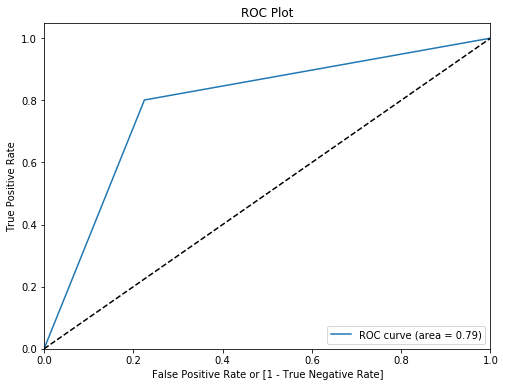

(array([0.        , 0.22474461, 1.        ]),
 array([0.        , 0.80093952, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [25]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),          
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', LinearSVC()),
])

data_4 = data_2[['review_text', 'rating', 'verified_purchase', 'sentiment','label']]
data_4['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_4['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_4[['review_text', 'rating', 'verified_purchase']], \
                                                    data_4['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')

print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)
plot_roc(y_test, pred)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 77.33%
Confusion matrix:
[[2678  822]
 [ 749 2681]]
[[2678  822]
 [ 749 2681]]
sensitivity :  0.7814414940180916
specifity :  0.7653439908649728
false positive rate :  0.23465600913502713
positive predictive rate :  0.7651428571428571
Negative predictive rate :  0.7816326530612245


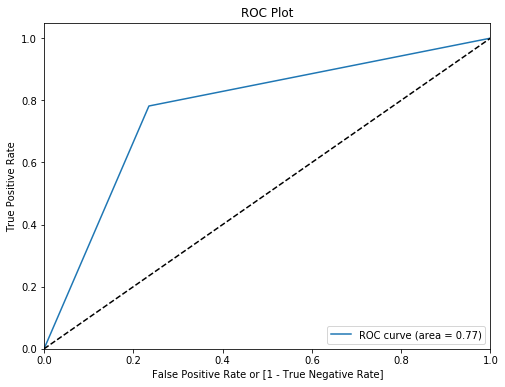

(array([0.        , 0.23485714, 1.        ]),
 array([0.        , 0.78163265, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [26]:
#Trying SVM on sentiment!!!

pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),
            #Somehow SVM is working even without this.
             ('review_text_tfidf', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
             ('verified_purchase', Pipeline([
                 ('selector', ItemSelector(key='verified_purchase')),
                 ('verified_dict', TfidfVectorizer())
             ]))
        ]
    )),
    ('classifier', LinearSVC()),
])

data_6 = data_2[['review_text', 'rating', 'verified_purchase', 'pr_category', 'sentiment','label']]
data_6['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_6['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_6[['review_text', 'rating', 'verified_purchase', 'pr_category']], \
                                                    data_6['label'], \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

In [27]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text_tfidf', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english", max_df=0.95)),
            ])),
             ('review_text', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(ngram_range=(1, 7), analyzer='char', stop_words="english")),
             ])),    
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
           ])),    
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', LinearSVC(C=0.2))
])

data_7 = data_2[['review_text', 'rating', 'verified_purchase', 'avg_len_tokens', 'pr_category', 'num_stopwords', 'flesch_kincaid', 'sentiment', 'label']]
data_7['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_7['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
data_7['avg_len_tokens'] = data.apply(lambda row: 'avg_token_' + str(int(round(row['avg_len_tokens'], 0))), axis=1)
data_7['num_stopwords'] = data.apply(lambda row: 'num_stop_' + str(row['num_stopwords']), axis=1)
data_7['flesch_kincaid'] = data.apply(lambda row: 'fk_' + str(round(row['flesch_kincaid'], 0)), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_7[['review_text', 'rating', 'avg_len_tokens', 'pr_category', 'verified_purchase', 'num_stopwords', 'avg_len_tokens']], \
                                                    data_7['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['fake', 'real'])
print('Confusion matrix:')
print(cm)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Classifier accuracy: 81.92%
Confusion matrix:
[[2791  733]
 [ 520 2886]]


In [28]:
data_2['sentiment'] = data_2.apply(lambda row: get_sent(row['rating']), axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_2['review_text'], data_2['sentiment'], test_size=0.33, random_state=1)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#feature_names = tfidf_vectorizer.get_feature_names()
#dense = tfidf_train.todense()
#denselist = dense.tolist()
tfidf_train.shape
tfidf_test = tfidf_vectorizer.transform(X_test)

svm_classifier = LinearSVC()
svm_classifier.fit(tfidf_train, y_train)
pred = svm_classifier.predict(tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')

cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'neutral', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)

Classifier accuracy: 82.41%
Confusion matrix:
[[ 547   57  381]
 [ 116   43  436]
 [ 132   97 5121]]
sensitivity :  0.8250377073906485
specifity :  0.43
false positive rate :  0.57
positive predictive rate :  0.9056291390728477
Negative predictive rate :  0.27044025157232704


In [29]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('review_text_length', None),
     ('verified_purchase', None),
    ('avg_len_tokens', None),
    ('num_stopwords', None),
    ('word_count', None),
    ('syll_count', None),
    ('flesch_kincaid', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
accuracy*100




C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


74.3001443001443

In [30]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('avg_len_tokens', None),
     #('pr_category', None),
    ('verified_purchase', None),
    ('num_stopwords', None),
    ('avg_len_tokens', None),
    #('syll_count', None),
    #('flesch_kincaid', None),
#     ('review_text_length', None),
#     ('review_title_length', None),
#     ('num_tokens', None),
#     ('word_count', None),
#     ('sent_count', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = LinearSVC(C=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
accuracy*100

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


80.01443001443002

In [31]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [50,100,150,200,500]
}

In [32]:
classifier=XGBClassifier()

In [33]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)


In [34]:
y = data_2[['label']]
X_train, X_test, y_train, y_test = train_test_split(data_2['review_text'], y, test_size=0.33, random_state=1)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names()
tfidf_test = tfidf_vectorizer.transform(X_test)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
random_search.fit(tfidf_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           num_parallel_tree=None,
                                           predictor=None, random_state

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 80.91%
Confusion matrix:
[[2658  842]
 [ 481 2949]]
sensitivity :  0.8467664861420835
specifity :  0.7778950145080453
false positive rate :  0.22210498549195462
positive predictive rate :  0.7594285714285715
Negative predictive rate :  0.8597667638483965


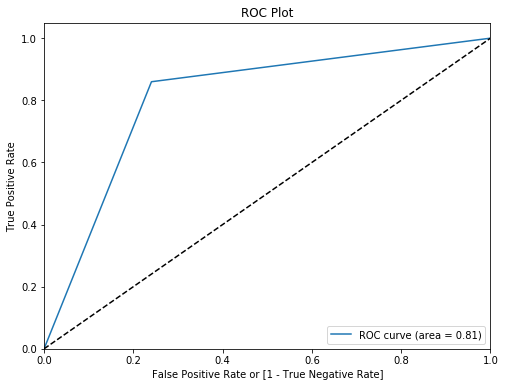

(array([0.        , 0.24057143, 1.        ]),
 array([0.        , 0.85976676, 1.        ]),
 array([2, 1, 0]))

In [36]:
#Trying XGBoostClassifier on sentiment!!!
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#data_xgb = data_2
#data_xgb['label'] = data_xgb['label'].apply(lambda x: 1 if x=='real' else 0)
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),
            #Somehow SVM is working even without this.
             ('review_text_tfidf', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
             ('verified_purchase', Pipeline([
                 ('selector', ItemSelector(key='verified_purchase')),
                 ('verified_dict', TfidfVectorizer())
             ]))
        ]
    )),
    ('classifier', XGBClassifier()),
])

data_xgb = data_2[['review_text', 'rating', 'verified_purchase', 'pr_category', 'sentiment','label']]
data_xgb['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_xgb['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_xgb[['review_text', 'rating', 'verified_purchase', 'pr_category']], \
                                                    data_xgb['label'], \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

In [37]:
data_2['sentiment'] = data_2.apply(lambda row: get_sent(row['rating']), axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_2['review_text'], data_2['sentiment'], test_size=0.33, random_state=1)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#feature_names = tfidf_vectorizer.get_feature_names()
#dense = tfidf_train.todense()
#denselist = dense.tolist()
tfidf_train.shape
tfidf_test = tfidf_vectorizer.transform(X_test)

svm_classifier = XGBClassifier()
svm_classifier.fit(tfidf_train, y_train)
pred = svm_classifier.predict(tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')

cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'neutral', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['negative' 'neutral' 'positive']

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 81.0%
Confusion matrix:
[[2686  838]
 [ 479 2927]]
sensitivity :  0.8486571879936808
specifity :  0.7774236387782204
false positive rate :  0.22257636122177954
positive predictive rate :  0.7622020431328036
Negative predictive rate :  0.85936582501468


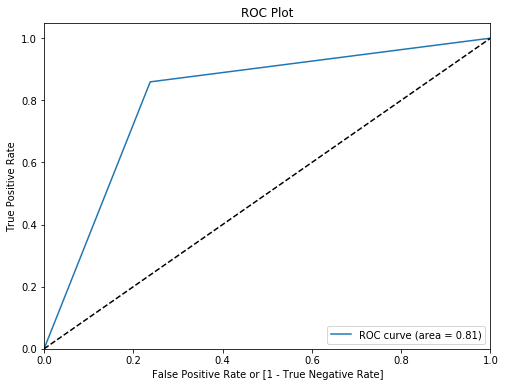

(array([0.        , 0.23779796, 1.        ]),
 array([0.        , 0.85936583, 1.        ]),
 array([2, 1, 0]))

In [38]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),
            
             #('pr_category', Pipeline([
              #   ('selector', ItemSelector(key='pr_category')),
               #  ('count_dict', TfidfVectorizer(stop_words="english")),
             #])),            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', XGBClassifier()),
])

data_4 = data_2[['review_text', 'rating', 'verified_purchase', 'sentiment','label']]
data_4['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_4['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_4[['review_text', 'rating', 'verified_purchase']], \
                                                    data_4['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)
print('Confusion matrix:')

print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
#plot_roc(y_test, pred)
plot_roc(y_test, pred)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 80.91%
Confusion matrix:
[[2658  842]
 [ 481 2949]]
[[2658  842]
 [ 481 2949]]
sensitivity :  0.8467664861420835
specifity :  0.7778950145080453
false positive rate :  0.22210498549195462
positive predictive rate :  0.7594285714285715
Negative predictive rate :  0.8597667638483965


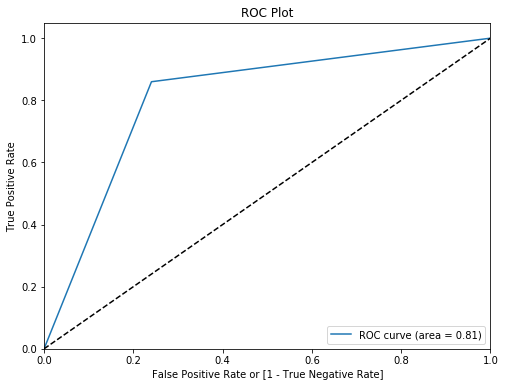

(array([0.        , 0.24057143, 1.        ]),
 array([0.        , 0.85976676, 1.        ]),
 array([2, 1, 0]))

In [39]:
#Trying SVM on sentiment!!!

pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),
            #Somehow SVM is working even without this.
             ('review_text_tfidf', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
             ('verified_purchase', Pipeline([
                 ('selector', ItemSelector(key='verified_purchase')),
                 ('verified_dict', TfidfVectorizer())
             ]))
        ]
    )),
    ('classifier', XGBClassifier()),
])

data_6 = data_2[['review_text', 'rating', 'verified_purchase', 'pr_category', 'sentiment','label']]
data_6['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_6['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_6[['review_text', 'rating', 'verified_purchase', 'pr_category']], \
                                                    data_6['label'], \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

In [40]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text_tfidf', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english", max_df=0.95)),
            ])),
             ('review_text', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(ngram_range=(1, 7), analyzer='char', stop_words="english")),
             ])),    
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
           ])),    
                         
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', XGBClassifier())
])

data_7 = data_2[['review_text', 'rating', 'verified_purchase', 'avg_len_tokens', 'pr_category', 'num_stopwords', 'flesch_kincaid', 'sentiment', 'label']]
data_7['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_7['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
data_7['avg_len_tokens'] = data.apply(lambda row: 'avg_token_' + str(int(round(row['avg_len_tokens'], 0))), axis=1)
data_7['num_stopwords'] = data.apply(lambda row: 'num_stop_' + str(row['num_stopwords']), axis=1)
data_7['flesch_kincaid'] = data.apply(lambda row: 'fk_' + str(round(row['flesch_kincaid'], 0)), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_7[['review_text', 'rating', 'avg_len_tokens', 'pr_category', 'verified_purchase', 'num_stopwords', 'avg_len_tokens']], \
                                                    data_7['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['fake', 'real'])
print('Confusion matrix:')
print(cm)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Classifier accuracy: 81.01%
Confusion matrix:
[[2751  773]
 [ 543 2863]]


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Classifier accuracy: 80.91%
Confusion matrix:
[[2658  842]
 [ 481 2949]]
sensitivity :  0.8467664861420835
specifity :  0.7778950145080453
false positive rate :  0.22210498549195462
positive predictive rate :  0.7594285714285715
Negative predictive rate :  0.8597667638483965


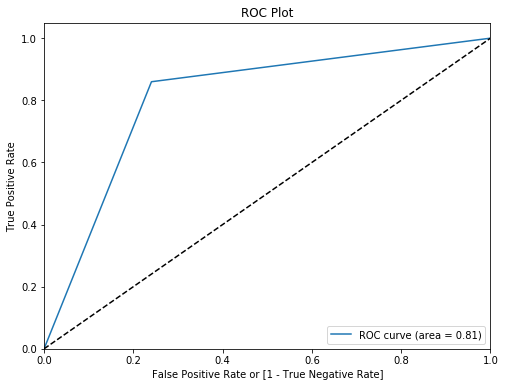

(array([0.        , 0.24057143, 1.        ]),
 array([0.        , 0.85976676, 1.        ]),
 array([2, 1, 0]))

In [41]:
#Trying XGBoostClassifier on sentiment!!!
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#data_xgb = data_2
#data_xgb['label'] = data_xgb['label'].apply(lambda x: 1 if x=='real' else 0)
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english")),
            ])),
            #Somehow SVM is working even without this.
             ('review_text_tfidf', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
             ])),            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
             ('verified_purchase', Pipeline([
                 ('selector', ItemSelector(key='verified_purchase')),
                 ('verified_dict', TfidfVectorizer())
             ]))
        ]
    )),
    ('classifier', XGBClassifier()),
])

data_xgb = data_2[['review_text', 'rating', 'verified_purchase', 'pr_category', 'sentiment','label']]
data_xgb['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_xgb['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_xgb[['review_text', 'rating', 'verified_purchase', 'pr_category']], \
                                                    data_xgb['label'], \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Classifier accuracy: 81.01%
Confusion matrix:
[[2751  773]
 [ 543 2863]]
sensitivity :  0.8351548269581056
specifity :  0.7874037403740374
false positive rate :  0.2125962596259626
positive predictive rate :  0.7806469920544835
Negative predictive rate :  0.8405754550792719


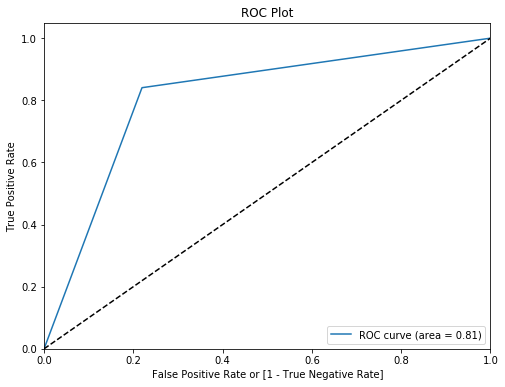

(array([0.        , 0.21935301, 1.        ]),
 array([0.        , 0.84057546, 1.        ]),
 array([2, 1, 0]))

In [42]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text_tfidf', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english", max_df=0.95)),
            ])),
             ('review_text', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(ngram_range=(1, 7), analyzer='char', stop_words="english")),
             ])),    
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
           ])),    
            
#             avg_len_tokens
#             num_stopwords
#             flesch_kincaid
#             sentiment
#             ('flesch_kincaid', Pipeline([
#                 ('selector', ItemSelector(key='flesch_kincaid')),
#                 ('rating_dict', CountVectorizer())
#             ])),                
#             ('avg_len_tokens', Pipeline([
#                 ('selector', ItemSelector(key='avg_len_tokens')),
#                 ('rating_dict', CountVectorizer())
#             ])),               
#             ('stops', Pipeline([
#                 ('selector', ItemSelector(key='num_stopwords')),
#                 ('rating_dict', CountVectorizer())
#             ])),    
#             ('sentiment', Pipeline([
#                 ('selector', ItemSelector(key='avg_len_tokens')),
#                 ('rating_dict', CountVectorizer())
#             ])),             
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', XGBClassifier())
])

data_7 = data_2[['review_text', 'rating', 'verified_purchase', 'avg_len_tokens', 'pr_category', 'num_stopwords', 'flesch_kincaid', 'sentiment', 'label']]
data_7['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_7['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
data_7['avg_len_tokens'] = data.apply(lambda row: 'avg_token_' + str(int(round(row['avg_len_tokens'], 0))), axis=1)
data_7['num_stopwords'] = data.apply(lambda row: 'num_stop_' + str(row['num_stopwords']), axis=1)
data_7['flesch_kincaid'] = data.apply(lambda row: 'fk_' + str(round(row['flesch_kincaid'], 0)), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_7[['review_text', 'rating', 'avg_len_tokens', 'pr_category', 'verified_purchase', 'num_stopwords', 'avg_len_tokens']], \
                                                    data_7['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['fake', 'real'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[07:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "param" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


AUC: 87.20%


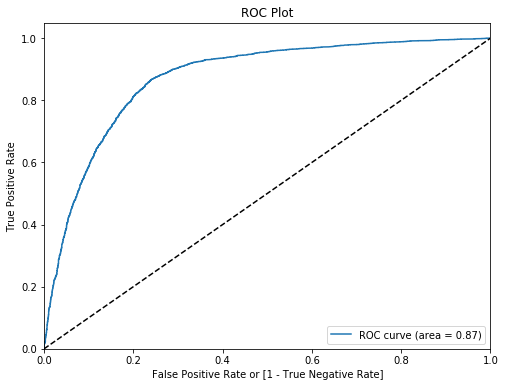

AUC: 87.20%


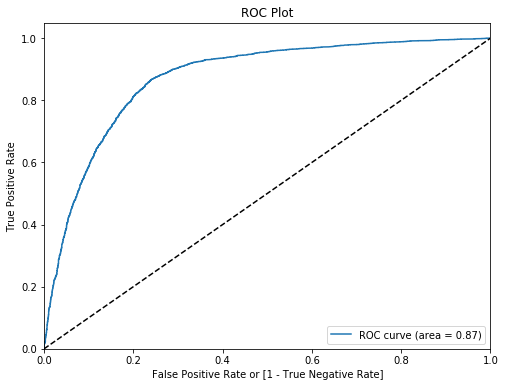

(array([0.        , 0.        , 0.        , ..., 0.99942857, 0.99971429,
        1.        ]),
 array([0.00000000e+00, 2.91545190e-04, 5.83090379e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.9939201 , 0.9939201 , 0.99009156, ..., 0.00555123, 0.00470253,
        0.00273325], dtype=float32))

In [43]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':500,
          'subsample':0.6,
         'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('review_text_length', None),
     ('verified_purchase', None),
    ('avg_len_tokens', None),
    ('num_stopwords', None),
    ('word_count', None),
    ('syll_count', None),
    ('flesch_kincaid', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = XGBClassifier(param=params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])
#score = metrics.accuracy_score(y_test, y_pred)
# print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
# cm = metrics.confusion_matrix(y_test, y_pred)#, labels=['fake', 'real'])
# print('Confusion matrix:')
# print(cm)
# TP = cm[0,0] 
# TN = cm[1,1] 
# FP = cm[0,1] 
# FN = cm[1,0] 
# #sensitivity
# print("sensitivity : ", TP / float(TP+FN))
# #specifity
# print("specifity : ", TN / float(TN+FP))
# # false positive rate
# print("false positive rate : ", FP/ float(TN+FP))
# # positive predictive rate
# print ( "positive predictive rate : ",TP / float(TP+FP))
# # Negative predictive rate
# print ("Negative predictive rate : ", TN / float(TN+ FN))
# plot_roc(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])
# score = metrics.accuracy_score(y_test, y_pred)
# print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
# cm = metrics.confusion_matrix(y_test, y_pred[:,1])#, labels=['fake', 'real'])
# print('Confusion matrix:')
# print(cm)
# TP = cm[0,0] 
# TN = cm[1,1] 
# FP = cm[0,1] 
# FN = cm[1,0] 
# #sensitivity
# print("sensitivity : ", TP / float(TP+FN))
# #specifity
# print("specifity : ", TN / float(TN+FP))
# # false positive rate
# print("false positive rate : ", FP/ float(TN+FP))
# # positive predictive rate
# print ( "positive predictive rate : ",TP / float(TP+FP))
# # Negative predictive rate
# print ("Negative predictive rate : ", TN / float(TN+ FN))

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[07:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "param" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


AUC: 87.20%


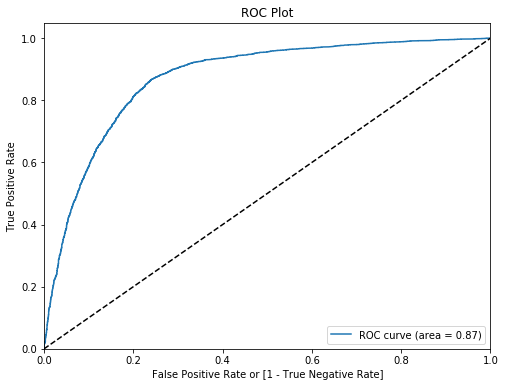

AUC: 87.20%


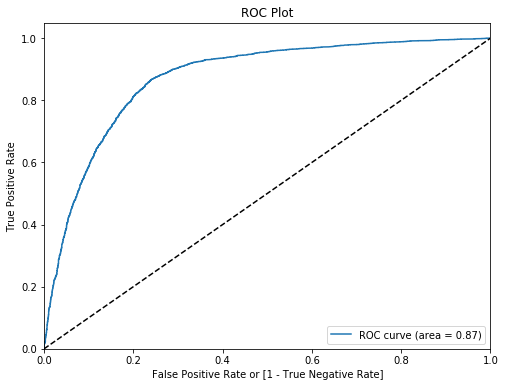

(array([0.        , 0.        , 0.        , ..., 0.99942857, 0.99971429,
        1.        ]),
 array([0.00000000e+00, 2.91545190e-04, 5.83090379e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.9939201 , 0.9939201 , 0.99009156, ..., 0.00555123, 0.00470253,
        0.00273325], dtype=float32))

In [44]:


params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('review_text_length', None),
     ('verified_purchase', None),
    ('avg_len_tokens', None),
    ('num_stopwords', None),
    ('word_count', None),
    ('syll_count', None),
    ('flesch_kincaid', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = XGBClassifier(param=params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])

In [45]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('avg_len_tokens', None),
     #('pr_category', None),
    ('verified_purchase', None),
    ('num_stopwords', None),
    ('avg_len_tokens', None),
    #('syll_count', None),
    #('flesch_kincaid', None),
#     ('review_text_length', None),
#     ('review_title_length', None),
#     ('num_tokens', None),
#     ('word_count', None),
#     ('sent_count', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = XGBClassifier(param=params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
accuracy*100

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[07:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "param" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




80.93795093795094

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data_3['review_text'], data_3['label'], test_size=0.33, random_state=1)

# Initialize a CountVectorizer and Tfidf objects
#count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data using only the 'text' column values: count_train 
#count_train = count_vectorizer.fit_transform(X_train)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
mlp = MLPClassifier(max_iter=500, activation='relu')
mlp


MLPClassifier(max_iter=500)

In [47]:
mlp.fit(tfidf_train,y_train)
pred = mlp.predict(tfidf_test)
pred
confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59      3524
           1       0.58      0.58      0.58      3406

    accuracy                           0.59      6930
   macro avg       0.59      0.59      0.59      6930
weighted avg       0.59      0.59      0.59      6930



In [48]:
cm = confusion_matrix(y_test,pred)
cm

array([[2098, 1426],
       [1442, 1964]], dtype=int64)

0.5861471861471862
sensitivity :  0.5926553672316384
specifity :  0.5793510324483776
false positive rate :  0.4206489675516224
positive predictive rate :  0.5953461975028377
Negative predictive rate :  0.5766294773928362


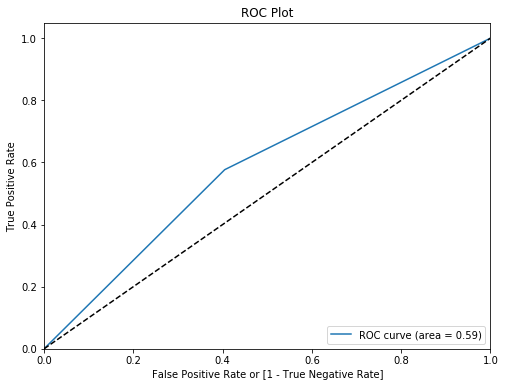

(array([0.       , 0.4046538, 1.       ]),
 array([0.        , 0.57662948, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [49]:
score = metrics.accuracy_score(y_test, pred)
print(score)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

In [50]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [51]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(tfidf_train, y_train)

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [52]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}


C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Classifier accuracy: 80.29%
Confusion matrix:
[[2800  724]
 [ 642 2764]]
sensitivity :  0.8134805345729227
specifity :  0.7924311926605505
false positive rate :  0.20756880733944955
positive predictive rate :  0.7945516458569807
Negative predictive rate :  0.8115091015854374


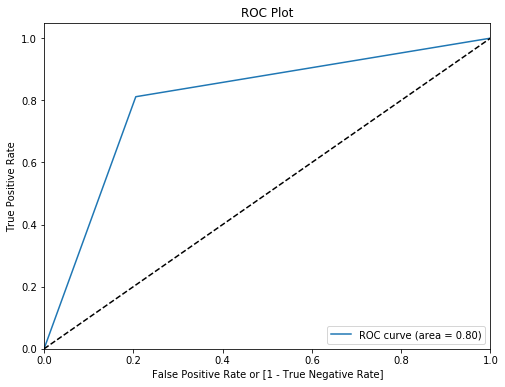

(array([0.        , 0.20544835, 1.        ]),
 array([0.       , 0.8115091, 1.       ]),
 array([2, 1, 0], dtype=int64))

In [53]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text_tfidf', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english", max_df=0.95)),
            ])),
             ('review_text', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(ngram_range=(1, 7), analyzer='char', stop_words="english")),
             ])),    
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
           ])),    
            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', MLPClassifier())
])

data_mlp = data_2[['review_text', 'rating', 'verified_purchase', 'avg_len_tokens', 'pr_category', 'num_stopwords', 'flesch_kincaid', 'sentiment', 'label']]
data_mlp['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_mlp['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
data_mlp['avg_len_tokens'] = data.apply(lambda row: 'avg_token_' + str(int(round(row['avg_len_tokens'], 0))), axis=1)
data_mlp['num_stopwords'] = data.apply(lambda row: 'num_stop_' + str(row['num_stopwords']), axis=1)
data_mlp['flesch_kincaid'] = data.apply(lambda row: 'fk_' + str(round(row['flesch_kincaid'], 0)), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_mlp[['review_text', 'rating', 'avg_len_tokens', 'pr_category', 'verified_purchase', 'num_stopwords', 'avg_len_tokens']], \
                                                    data_mlp['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['fake', 'real'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))
plot_roc(y_test, pred)

In [55]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      3524
           1       0.62      0.62      0.62      3406

    accuracy                           0.63      6930
   macro avg       0.63      0.63      0.63      6930
weighted avg       0.63      0.63      0.63      6930



C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


AUC: 51.52%


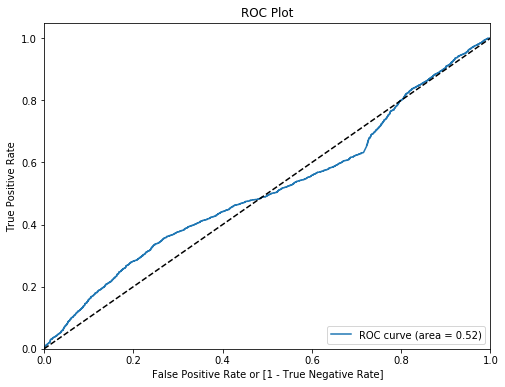

AUC: 51.52%


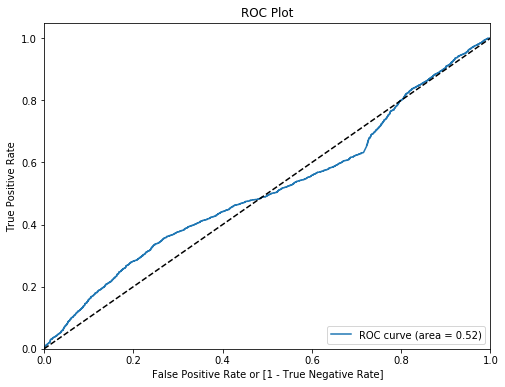

(array([0.        , 0.        , 0.        , ..., 0.99942857, 0.99971429,
        1.        ]),
 array([0.00000000e+00, 2.91545190e-04, 5.83090379e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.66648247, 0.66648247, 0.66356117, ..., 0.48663848, 0.48663269,
        0.48660158]))

In [58]:
# params = {'learning_rate': 0.2,
#           'max_depth': 2, 
#           'n_estimators':200,
#           'subsample':0.6,
#          'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('review_text_length', None),
     ('verified_purchase', None),
    ('avg_len_tokens', None),
    ('num_stopwords', None),
    ('word_count', None),
    ('syll_count', None),
    ('flesch_kincaid', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', alpha=0.05,
                     solver='sgd',learning_rate='constant')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


AUC: 83.33%


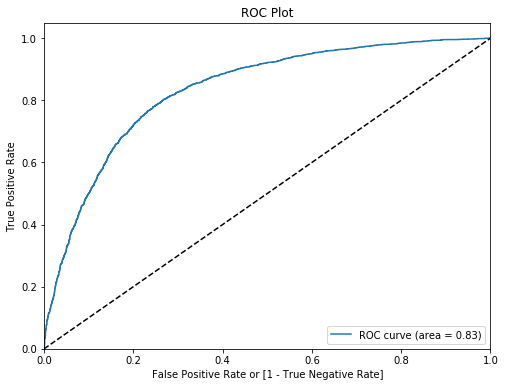

AUC: 83.33%


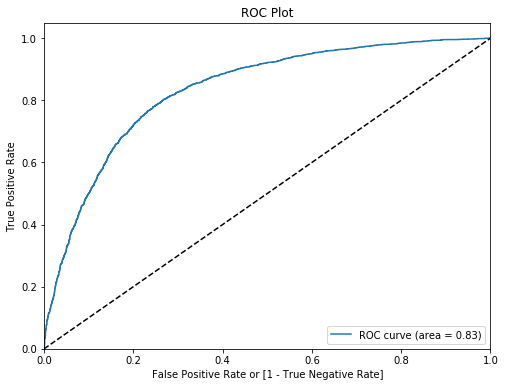

(array([0.00000000e+00, 2.85714286e-04, 2.85714286e-04, ...,
        9.99428571e-01, 9.99714286e-01, 1.00000000e+00]),
 array([0.0000000e+00, 0.0000000e+00, 2.9154519e-04, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]),
 array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.68200782e-08, 2.20646685e-08, 1.95862693e-08]))

In [59]:
# params = {'learning_rate': 0.2,
#           'max_depth': 2, 
#           'n_estimators':200,
#           'subsample':0.6,
#          'objective':'binary:logistic'}
mapper = DataFrameMapper([
     ('review_text', TfidfVectorizer(stop_words="english")),
     ('rating', None),
     ('review_text_length', None),
     ('verified_purchase', None),
    ('avg_len_tokens', None),
    ('num_stopwords', None),
    ('word_count', None),
    ('syll_count', None),
    ('flesch_kincaid', None),
    
 ])
features = mapper.fit_transform(data_3)
categories = data_3['label']

X_train, X_test, y_train, y_test = train_test_split( \
                                                    features,
                                                    categories, \
                                                    test_size=0.33, \
                                                    random_state=3
                                                    )

model = MLPClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))
plot_roc(y_test, y_pred[:,1])

C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\biplab_mazumdar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Classifier accuracy: 79.16%
Confusion matrix:
[[2567  957]
 [ 487 2919]]
sensitivity :  0.8405370006548788
specifity :  0.7530959752321982
false positive rate :  0.24690402476780185
positive predictive rate :  0.728433598183882
Negative predictive rate :  0.857017028772754
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      3524
           1       0.75      0.86      0.80      3406

    accuracy                           0.79      6930
   macro avg       0.80      0.79      0.79      6930
weighted avg       0.80      0.79      0.79      6930



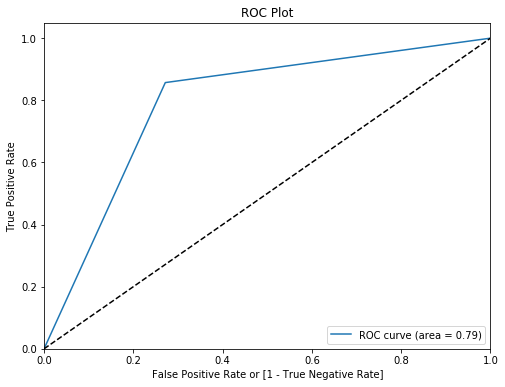

(array([0.       , 0.2715664, 1.       ]),
 array([0.        , 0.85701703, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [60]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
            ('review_text_tfidf', Pipeline([
                ('selector', ItemSelector(key='review_text')),
                ('count_dict', TfidfVectorizer(stop_words="english", max_df=0.95)),
            ])),
             ('review_text', Pipeline([
                 ('selector', ItemSelector(key='review_text')),
                 ('count_dict', TfidfVectorizer(ngram_range=(1, 7), analyzer='char', stop_words="english")),
             ])),    
             ('pr_category', Pipeline([
                 ('selector', ItemSelector(key='pr_category')),
                 ('count_dict', TfidfVectorizer(stop_words="english")),
           ])),    
            
            ('rating', Pipeline([
                ('selector', ItemSelector(key='rating')),
                ('rating_dict', TfidfVectorizer())
            ])),
            ('verified_purchase', Pipeline([
                ('selector', ItemSelector(key='verified_purchase')),
                ('verified_dict', TfidfVectorizer())
            ]))
        ]
    )),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', alpha=0.05,
                     solver='sgd',learning_rate='constant'))
])

data_mlp = data_2[['review_text', 'rating', 'verified_purchase', 'avg_len_tokens', 'pr_category', 'num_stopwords', 'flesch_kincaid', 'sentiment', 'label']]
data_mlp['rating'] = data.apply(lambda row: 'rating_' + str(row['rating']), axis=1)
data_mlp['verified_purchase'] = data.apply(lambda row: 'verified_' + str(row['verified_purchase']), axis=1)
data_mlp['avg_len_tokens'] = data.apply(lambda row: 'avg_token_' + str(int(round(row['avg_len_tokens'], 0))), axis=1)
data_mlp['num_stopwords'] = data.apply(lambda row: 'num_stop_' + str(row['num_stopwords']), axis=1)
data_mlp['flesch_kincaid'] = data.apply(lambda row: 'fk_' + str(round(row['flesch_kincaid'], 0)), axis=1)
X_train, X_test, y_train, y_test = train_test_split( \
                                                    data_mlp[['review_text', 'rating', 'avg_len_tokens', 'pr_category', 'verified_purchase', 'num_stopwords', 'avg_len_tokens']], \
                                                    data_mlp['label'], \
                                                    test_size=0.33, \
                                                    random_state=1
                                                    )

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred)#, labels=['fake', 'real'])
print('Confusion matrix:')
print(cm)
TP = cm[0,0] 
TN = cm[1,1] 
FP = cm[0,1] 
FN = cm[1,0] 
#sensitivity
print("sensitivity : ", TP / float(TP+FN))
#specifity
print("specifity : ", TN / float(TN+FP))
# false positive rate
print("false positive rate : ", FP/ float(TN+FP))
# positive predictive rate
print ( "positive predictive rate : ",TP / float(TP+FP))
# Negative predictive rate
print ("Negative predictive rate : ", TN / float(TN+ FN))

print(classification_report(y_test,pred))
plot_roc(y_test, pred)

In [ ]:
# Model Comparison
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

classifiers = [
    RandomForestClassifier(),
    LogisticRegression()]


for clf in classifiers:
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    if name == 'LogisticRegression':
        print('****Results****')
        acc = accuracy_score(y_pred_final.churn, y_pred_final.final_predicted)
        print("Accuracy: {:.4%}".format(acc))
    else:
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy: {:.4%}".format(acc))
    
  
       
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

In [ ]:
sns.barplot(x='Accuracy', y='Classifier', data=log, color="g")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

plt.show()